# Exploratory Data Analysis of OTIM-DB

This notebook is a companion for the paper: [OTIM-DB, a database of near-saturated hydraulic  conductivity with management practice](https://doi.org/).

In [1]:
# import packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import folium
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
import re
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')

datadir = '../data/'
outputdir = '../figures/'
letters = 'abcdefghijklmnopqrstuvwxyz'

In [2]:
# read in OTIM database (new structure)
dfdic = pd.read_excel(datadir + 'OTIM-DB.xlsx', sheet_name=None, na_values=[-9999])
dfexp = dfdic['experiments']
dfloc = dfdic['locations']
dfref = dfdic['reference']
dfmeth = dfdic['method'].replace(-9999, np.nan)
dfsp = dfdic['soilProperties']
dfclim = dfdic['climate']
dfmod = dfdic['modelFit']
dfsm = dfdic['soilManagement'].replace(-9999, np.nan).replace(
    'no impact', 'consolidated').replace(  # estetic replacement
    'soon after tillage', 'soon after tillage')
dfraw = dfdic['rawData']

In [3]:
# merge tables
# NOTE good to merge on specific column (in case same column name appears...)
dfm = dfexp.merge(
    dfloc, how='left', on='Location').merge(
    dfref, how='left', on='ReferenceTag').merge(
    dfmeth, how='left', on='MethodName').merge(
    dfsp, how='left', on='SPName').merge(
    dfclim, how='left', on='ClimateName').merge(
    dfmod, how='left', on='MTFName').merge(
    dfsm, how='left', on='SMName')

# remove this entry as only one tension
dfm = dfm[dfm['ReferenceTag'].ne('kuhwald2017')].reset_index(drop=True)

# some old entries have Ks and Hmin but indicates Tmin > 5 mm... so we remove Ks and Hmin for them
ie = dfm['Kunsat'].notnull() & dfm['Tmin'].gt(5) & dfm['Ks'].notnull()
dfm.loc[ie, 'Ks'] = np.nan
dfm.loc[ie, 'Hmin'] = np.nan

print('number of entries (rows) initially in the db (as reported in papers):', dfm.shape[0])

number of entries (rows) initially in the db (as reported in papers): 1285


## Defining filters

Entries are kept if:
- they come from topsoil: `UpperD_m` < 0.2 m
- are well fitted: `R2` > 0.9
- measure the full range from 0 mm to 100 mm tension: `Tmax` >= 100 mm and `Tmin` == 0 mm

In [4]:
#set number of randomizations used to calculate the p-value (should be at least 1 / significance level.. better more)
randomizos = 200

#also set level of confidence
pval = 0.05

In [5]:
# define entries to keep but doesn't apply the filtering just yet
print('number of topsoil data: {:d} ({:.0f}%)'.format(
    dfm['UpperD_m'].lt(0.2).sum(), dfm['UpperD_m'].lt(0.2).sum()/dfm.shape[0]*100))

#base selection
#i2keep = dfm['R2'].ge(0.9) & dfm['Tmin'].le(5) & dfm['Tmax'].ge(80) & dfm['UpperD_m'].le(0.2) & dfm['SoilTextureFAO'].ne('organic')

#only common methods
#i2keep = dfm['R2'].ge(0.9) & dfm['Tmin'].le(5) & dfm['Tmax'].ge(80) & dfm['UpperD_m'].le(0.2) & dfm['SoilTextureFAO'].ne('organic') & dfm['Method'].ne('Steady-state constant') & dfm['Method'].ne('Steady-state constant  regression') & dfm['Direction'].ne('Wet to dry')

#only piece-wise
#i2keep = dfm['R2'].ge(0.9) & dfm['Tmin'].le(5) & dfm['Tmax'].ge(80) & dfm['UpperD_m'].le(0.2) & dfm['SoilTextureFAO'].ne('organic') & dfm['Method'].eq('Steady-state piecewise') & dfm['Direction'].ne('Wet to dry')

#only piece-wise and arable
i2keep = dfm['R2'].ge(0.9) & dfm['Tmin'].le(5) & dfm['Tmax'].ge(80) & dfm['UpperD_m'].le(0.2) & dfm['SoilTextureFAO'].ne('organic') & dfm['Method'].eq('Steady-state piecewise') & dfm['Direction'].ne('Wet to dry') & dfm['LanduseClass'].eq('arable')

#other selections
i2wet = dfm['Tmax'].lt(100) & dfm['Tmin'].ge(0)
i2dry = dfm['Tmax'].ge(100) & dfm['Tmin'].ge(10)
i2comp = dfm['Tmax'].ge(100) & dfm['Tmin'].le(5)
i2w2d = dfm['Direction'].eq('Wet to dry')
print('number of entries with complete series: {:d} out of {:d}'.format(i2keep.sum(), i2keep.shape[0]))
print('percent of entries with short series at wet end: {:.0f}%'.format(i2wet.sum()/i2keep.shape[0]*100))
print('percent of entries with short series at dry end: {:.0f}%'.format(i2dry.sum()/i2keep.shape[0]*100))
print('percent of entries with complete series: {:.0f}%'.format(i2comp.sum()/i2keep.shape[0]*100))
print('percent of wet-to-dry: {:.0f}%'.format(i2w2d.sum()/i2keep.shape[0]*100))
print('percent of entries extrapolated used: {:.0f}%'.format(dfm[i2keep]['Tmax'].between(80, 99).sum()/i2keep.shape[0]*100))

number of topsoil data: 1182 (92%)
number of entries with complete series: 193 out of 1285
percent of entries with short series at wet end: 39%
percent of entries with short series at dry end: 20%
percent of entries with complete series: 40%
percent of wet-to-dry: 14%
percent of entries extrapolated used: 0%


In [6]:
# list of columns grouped per categories
climate_factors_temp = [
    'AnnualMeanTemperature',
    'MeanTemperatureofWarmestQuarter',
    'MeanTemperatureofColdestQuarter', 
    'Isothermality',
    'TemperatureSeasonality',
    'MaxTemperatureofWarmestMonth',
    'MinTemperatureofColdestMonth',
    'TemperatureAnnualRange',
    'MeanTemperatureofWettestQuarter',
    'MeanTemperatureofDriestQuarter',
    'Elevation']

climate_factors_pre = [
    'AnnualPrecipitation',
    'PrecipitationofWettestMonth',
    'PrecipitationofDriestMonth',
    'PrecipitationSeasonality',
    'PrecipitationofWettestQuarter',
    'PrecipitationofDriestQuarter',
    'PrecipitationofWarmestQuarter',
    'PrecipitationofColdestQuarter',
    'MeanDiurnalRange',
    'Elevation',
#     'AverageAridityIndex',
#     'AverageAnnualEvapoTranspiration',
#     'AridityClass'
]

climate_factors = climate_factors_temp + climate_factors_pre

soil_factors = [
 'SoilTextureFAO',
 'SoilTextureUSDA',
 'ClayContent',
 'SiltContent',
 'SandContent',
 'BulkDensity',
 'SoilOrganicCarbon',
#  "SOC_trans"
]

method_factors = [
#  "Month1_sin",
#  "Month1_cos",
#  "Month2_sin",
#  "Month2_cos",
#  "Season_sin",
#  "Season_cos",
 'Method',
 'Direction',
 'Tmin',
 'Tmax',
 'UpperD_m',
 'Diameter'
]

management_factors = [
 'LanduseClass',
 'TillageClass',
 'NbOfCropRotation',
 'CropClass',
 'CoverCropClass',
 'ResidueClass',
 'GrazingClass',
 'IrrigationClass',
 'CompactionClass',
 'SamplingTimeClass',
 'AmendmentClass',
#  'ContainsCereals',
#  'ContainsFallow',
#  'ContainsGrassHerbs',
#  'ContainsLegume',
#  'ContainsMaize',
#  'ContainsTreesFruits',
#  'ContainsVegetables'
]

k_factors = [
 'log_Ks',
 'log_Kunsat',
 'log_k10',
 'log_k20',
 'log_k30',
 'log_k40',
 'log_k50',
 'log_k60',
 'log_k70',
 'log_k80',
 'log_k90',
 'log_k100'
]

factors = climate_factors + soil_factors + method_factors +\
            management_factors + k_factors

In [7]:
# print columns with object dtype to be sure they shouldn't be float
cols = climate_factors + soil_factors + method_factors + management_factors
dtypes = dfm[cols].dtypes
dtypes[dtypes == 'object']

SoilTextureFAO       object
SoilTextureUSDA      object
Method               object
Direction            object
LanduseClass         object
TillageClass         object
CropClass            object
CoverCropClass       object
ResidueClass         object
GrazingClass         object
IrrigationClass      object
CompactionClass      object
SamplingTimeClass    object
AmendmentClass       object
dtype: object

In [8]:
# some values are high but it's ok
dfm.sort_values('K10', ascending=False)[['MTFName', 'Ks', 'Kunsat', 'K10', 'slope', 'intercept']].head()

,MTFName,Ks,Kunsat,K10,slope,intercept
763,Greenwood2017BT_P3,NaN,129.3031,1616.251486,1.096900,4.305409
852,fashi2019_CT,1026.0000,NaN,1026.000000,1.567451,5.254756
853,fashi2019_NT,954.0000,NaN,954.000000,1.416284,4.980585
847,fashi2019_Abandoned,780.0000,NaN,780.000000,1.724093,5.385630
605,ZeinBarleyAug,778.9738,20.9000,778.973800,2.610000,6.540146


In [9]:
# removing super high values and computing log columns
kcols = ['Ks'] + ['K' + str((i+1)*10) for i in range(10)]

# filtering out unreasonable values
ibad = dfm['K10'] > 2000
print('setting {:d} entries with K too high to NaN'.format(np.sum(ibad)))
dfm.loc[ibad, kcols] = np.nan

# given the wide range of hydraulic conductivity values, we compute the log of K
for kcol in kcols:
    dfm['log_' + kcol] = np.log10(dfm[kcol])

setting 0 entries with K too high to NaN


## Map

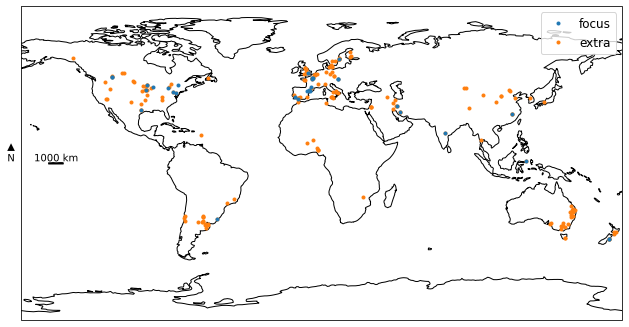

In [10]:
# https://stackoverflow.com/questions/32333870/how-can-i-show-a-km-ruler-on-a-cartopy-matplotlib-plot
import os
import cartopy.crs as ccrs
from math import floor
import matplotlib.pyplot as plt
from matplotlib import patheffects
import matplotlib



def utm_from_lon(lon):
    """
    utm_from_lon - UTM zone for a longitude

    Not right for some polar regions (Norway, Svalbard, Antartica)

    :param float lon: longitude
    :return: UTM zone number
    :rtype: int
    """
    return floor( ( lon + 180 ) / 6) + 1

def scale_bar(ax, proj, length, location=(0.52, 0.05), linewidth=2,
              units='km', m_per_unit=1000):
    """

    http://stackoverflow.com/a/35705477/1072212
    ax is the axes to draw the scalebar on.
    proj is the projection the axes are in
    location is center of the scalebar in axis coordinates ie. 0.5 is the middle of the plot
    length is the length of the scalebar in km.
    linewidth is the thickness of the scalebar.
    units is the name of the unit
    m_per_unit is the number of meters in a unit
    """
    # find lat/lon center to find best UTM zone
    x0, x1, y0, y1 = ax.get_extent(proj.as_geodetic())
    # Projection in metres
    utm = ccrs.UTM(utm_from_lon((x0+x1)/2))
    # Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(utm)
    # Turn the specified scalebar location into coordinates in metres
    sbcx, sbcy = x0 + (x1 - x0) * location[0], y0 + (y1 - y0) * location[1]
    # Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbcx - length * m_per_unit/2, sbcx + length * m_per_unit/2]
    # buffer for scalebar
    buffer = [patheffects.withStroke(linewidth=5, foreground="w")]
    # Plot the scalebar with buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, path_effects=buffer)
    # buffer for text
    buffer = [patheffects.withStroke(linewidth=3, foreground="w")]
    # Plot the scalebar label
    t0 = ax.text(sbcx, sbcy, str(length) + ' ' + units, transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    left = x0+(x1-x0)*0.05
    # Plot the N arrow
    t1 = ax.text(left, sbcy, u'\u25B2\nN', transform=utm,
        horizontalalignment='center', verticalalignment='bottom',
        path_effects=buffer, zorder=2)
    # Plot the scalebar without buffer, in case covered by text buffer
    ax.plot(bar_xs, [sbcy, sbcy], transform=utm, color='k',
        linewidth=linewidth, zorder=3)

fig = plt.figure(figsize=(10, 6))
#ax = plt.axes(projection=ccrs.InterruptedGoodeHomolosine())
ax = plt.axes(projection=ccrs.PlateCarree())
#plt.title('OTIMD entries')
#ax.set_extent([-180, 180, -80, 80])#, ccrs.Geodetic())
#ax.stock_img()
ax.coastlines()#resolution='10m')

scale_bar(ax, ccrs.PlateCarree(), 1000, location=(-2, 2))  # 100 km scale bar
# or to use m instead of km
# scale_bar(ax, ccrs.Mercator(), 100000, m_per_unit=1, units='m')
# or to use miles instead of km
# scale_bar(ax, ccrs.Mercator(), 60, m_per_unit=1609.34, units='miles')

# not used
xy = dfm[~i2keep][['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True).values
ax.plot(xy[:,1], xy[:,0], '.', color='tab:orange', transform=ccrs.PlateCarree())

# used
xy = dfm[i2keep][['Latitude', 'Longitude']].drop_duplicates().reset_index(drop=True).values
ax.plot(xy[:,1], xy[:,0], '.', color='tab:blue', transform=ccrs.PlateCarree())

#ax.set_aspect('auto')
matplotlib.rcParams.update({'font.size': 12})
ax.set_ylim([-90, 90])
cax1, = ax.plot([], [], '.', color='tab:blue', label='focus')
cax2, = ax.plot([], [], '.', color='tab:orange', label='extra')
ax.legend(handles=[cax1, cax2])
fig.tight_layout()
fig.savefig(outputdir + 'map.jpg', dpi=500)
plt.show()

## Tensions availables

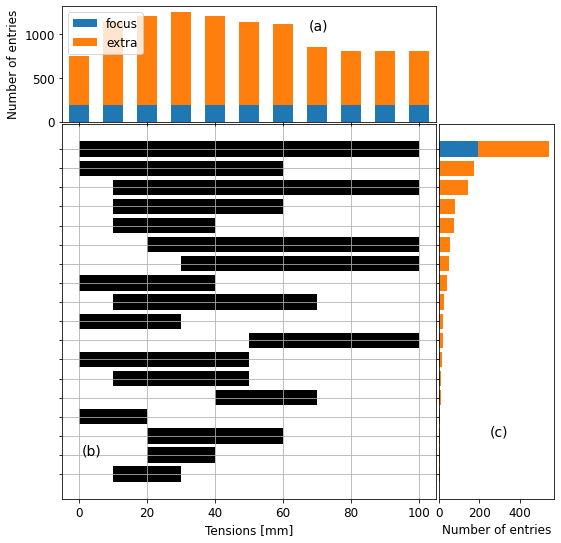

In [11]:
# available tension range
dfm2 = dfm.copy()

# interpolation we do when fitting K10
dfm2.loc[dfm2['Tmax'].ge(75), 'Tmax'] = 100

bins = np.arange(0, 100, 10)
def func(x):
    return np.round(x/10, 0)*10
dfm2['Tmin'] = dfm2['Tmin'].apply(func)
dfm2['Tmax'] = dfm2['Tmax'].apply(func)
dfm2.loc[dfm2['Tmax'].gt(100), 'Tmax'] = 100
dfm2['used'] = 'not used'
dfm2.loc[i2keep, 'used'] = 'used'

#dfcount = dfm2.groupby(['used', 'Tmin', 'Tmax']).count().reset_index()
#dfcount = dfcount[dfcount['Method'] > 0].reset_index(drop=True).sort_values('Method')
dfcount = dfm2.groupby(['used', 'Tmin', 'Tmax']).count().reset_index()
# get the order of the Tmin-Tmax range
df = dfcount.groupby(['Tmin', 'Tmax']).sum().sort_values('Method').reset_index()
tmin = df['Tmin'].values
tmax = df['Tmax'].values

# for the histograme per range
#dfcount2 = dfm2.groupby(['used', 'Tmin', 'Tmax']).count().reset_index()
#dfcount = dfcount.sort_values(['used', 'Method'], ascending=[False, False])
# iused = dfcount['used'].eq('used')
# count_used = dfcount[iused]['Method'].values
# y_used = np.arange(dfcount[iused].shape[0])
# inotused = dfcount['used'].eq('used')
# count_notused = dfcount[inotused]['Method'].values
# y_notused = np.arange(dfcount[inotused].shape[0])

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
spacing = 0.005
rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom + height + spacing, width, 0.2]
rect_histy = [left + width + spacing, bottom, 0.2, height]

# start with a square Figure showing the range
fig = plt.figure(figsize=(8, 8))
ax = fig.add_axes(rect_scatter)
ax.barh(np.arange(len(tmin)), left=tmin, width=tmax - tmin, color='k')
ax.set_yticks(np.arange(len(tmin)))
ax.set_yticklabels([])
ax.grid(True)
ax.set_xlabel('Tensions [mm]')
ax.set_xlim([-5, 105])
#ax.set_ylim([-0.6, None])
ax.annotate('(b)', (1, 1), fontsize=14)

# histogram of number of entries per tension
ax_histx = fig.add_axes(rect_histx, sharex=ax)
#s1 = dfm[~i2keep][kcols].notnull().sum()#/dfm.shape[0]*100
#s2 = dfm[i2keep][kcols].notnull().sum()
#df = pd.DataFrame([s2, s1]).T.rename(columns={1: 'not used', 0: 'used'})
#df.plot.bar(stacked=True,
#           ylabel='Number of entries', ax=ax_histx)
s = dfm2[i2keep][kcols].notnull().sum()
ax_histx.bar(np.arange(0, s.shape[0])*10, s.values, width=6, label='focus')
s2 = dfm2[~i2keep][kcols].notnull().sum()
ax_histx.bar(np.arange(0, s2.shape[0])*10, s2.values, bottom=s.values,
             width=6, color='tab:orange', label='extra')
ax_histx.legend()
ax_histx.set_ylabel('Number of entries')
ax_histx.tick_params(axis="x", labelbottom=False)
ax_histx.annotate('(a)', (67.5, 1050), fontsize=14)

# histogram of number of entries per tension range
ax_histy = fig.add_axes(rect_histy, sharey=ax)
for i, (a, b) in enumerate(zip(tmin, tmax)):
    c1 = dfcount[dfcount['Tmin'].eq(a) 
                 & dfcount['Tmax'].eq(b) 
                 & dfcount['used'].eq('used')]['Method'].values
    c1 = c1[0] if len(c1) > 0 else 0
    ax_histy.barh(i, c1, color='tab:blue')
    c2 = dfcount[dfcount['Tmin'].eq(a) 
                 & dfcount['Tmax'].eq(b) 
                 & dfcount['used'].eq('not used')]['Method'].values
    c2 = c2[0] if len(c2) > 0 else 0
    ax_histy.barh(i, c2, left=c1, color='tab:orange')
#ax_histy.barh(y, width=count)
ax_histy.set_xlabel('Number of entries')
ax_histy.tick_params(axis="y", labelleft=False)
ax_histy.annotate('(c)', (250, 2), fontsize=14)

fig.savefig(outputdir + 'range-tension.jpg', dpi=500)

In [12]:
# new entries as in table
cols = ['LanduseClass', 'TillageClass', 'CompactionClass', 'SamplingTimeClass']
inew = dfm['ReferenceYear'].ge(2013) & dfm['ReferenceTag'].apply(lambda x: len(x.split('_')) < 3).astype(bool)
def concat(x):
    return ' | '.join(x.unique())
dico = dict(zip(cols, [concat]*len(cols)))
dico.update({'RefID': 'count'})
df = dfm[inew].groupby('ReferenceTag').agg(dico).reset_index()
df = df.rename(columns={
    'ReferenceTag': 'Reference',
    'RefID': 'Number of entries',
    'LanduseClass': 'Land use',
    'TillageClass': 'Tillage',
    'CompactionClass': 'Compaction',
    'SamplingTimeClass': 'Sampling time'})
def formatref(x):
    return x[:-4].capitalize() + ' et al. ' + x[-4:]
df['Reference'] = df['Reference'].apply(formatref).replace({
    'Deboever et al. 2016': 'De Boever et al. 2016',
    'Beiblei et al. 2016': 'Zhou et al. 2016',
    'Zeng2 et al. 013b': 'Zeng et al. 2013b',
})
df.sort_values('Reference').style.hide_index()

Reference,Land use,Tillage,Compaction,Sampling time,Number of entries
Alagna et al. 2016,grassland,no tillage,not compacted,consolidated,1
Alletto et al. 2015,arable,conventional tillage,unknown,consolidated,60
Bagarello et al. 2014,arable,no tillage | conventional tillage,unknown,unknown,10
Batkova et al. 2020,arable,reduced tillage | no tillage | conventional tillage,unknown,consolidated | after tillage,12
Bodner et al. 2013,arable,no tillage,unknown,after tillage | consolidated,12
Bottinelli et al. 2013,arable,unknown | conventional tillage | reduced tillage | no tillage,unknown,consolidated,10
Costa et al. 2015,arable,conventional tillage | reduced tillage | no tillage,not compacted,consolidated,3
De Boever et al. 2016,grassland,no tillage,not compacted,unknown,6
Fashi et al. 2019,arable,no tillage | reduced tillage | conventional tillage,compacted | not compacted,unknown,8
Fasinmirin et al. 2018,arable | woodland/plantation | grassland,conventional tillage | no tillage,not compacted | compacted,unknown,3


In [13]:
# how many mini-disk entries -> not so many
a = (dfm['Diameter'].eq(4.5) | dfm['Diameter'].eq(4.45)).sum()
dff = dfm.groupby('ReferenceTag').first()
b = (dff['Diameter'].eq(4.5) | dff['Diameter'].eq(4.45)).sum()
print('{:d}/{:d} entries in {:d}/{:d} papers'.format(a, len(dfm), b, len(dff)))
ie = dff['ReferenceYear'].gt(2013)
b = (dff[ie]['Diameter'].eq(4.5) | dff[ie]['Diameter'].eq(4.45)).sum()
print('after 2013: {:d}/{:d} entries in {:d}/{:d} papers'.format(a, len(dfm), b, len(dff)))

dff = dfm.groupby('ReferenceTag').first()
print(dff[dff['Diameter'].eq(4.5)].index)

#dfm['Diameter'].value_counts()

148/1285 entries in 10/171 papers
after 2013: 148/1285 entries in 9/171 papers
Index(['Caldwell_2008_GRL', 'Fasinmirin2018', 'Lopes2020', 'Wanniarachchi2019',
       'batkova2020', 'hallam2020', 'lozano2020', 'wang2022', 'zhao2014'],
      dtype='object', name='ReferenceTag')


## Publication year of papers

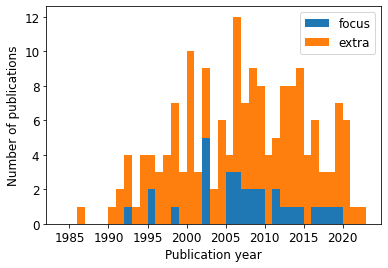

In [14]:
# number of papers per publication year
dfref = dfdic['reference']
fig, ax = plt.subplots()
pubin = dfm[i2keep].groupby('ReferenceTag').first()['ReferenceYear']
pubout = dfm[~i2keep].groupby('ReferenceTag').first()['ReferenceYear']
pubout = pubout[~pubout.index.isin(pubin.index)]  # ref is "in" if at least one pub is taken after filtering
ax.hist([pubin, pubout], bins=np.arange(1984, 2024, 1), stacked=True)
ax.set_xlabel('Publication year')
ax.set_ylabel('Number of publications')
ax.legend(['focus', 'extra'])
fig.savefig(outputdir + 'publication-years.jpg', dpi=300)

In [15]:
count, year = np.histogram(dfref[dfref['ReferenceYear'].ge(2000)]['ReferenceYear'], bins=np.arange(2000, 2020, 1))
print('average number of publication since 2000: {:.1f} publications/year'.format(np.average(count)))

average number of publication since 2000: 6.7 publications/year


In [16]:
# how many publications and entries after 2012
ie = dfm['ReferenceYear'].gt(2012)
print('{:d} new entries from {:d} new publications after 2012'.format(
    ie.sum(), dfm[ie].groupby('ReferenceName').first().shape[0]))

565 new entries from 48 new publications after 2012


## Descriptive statistics of features

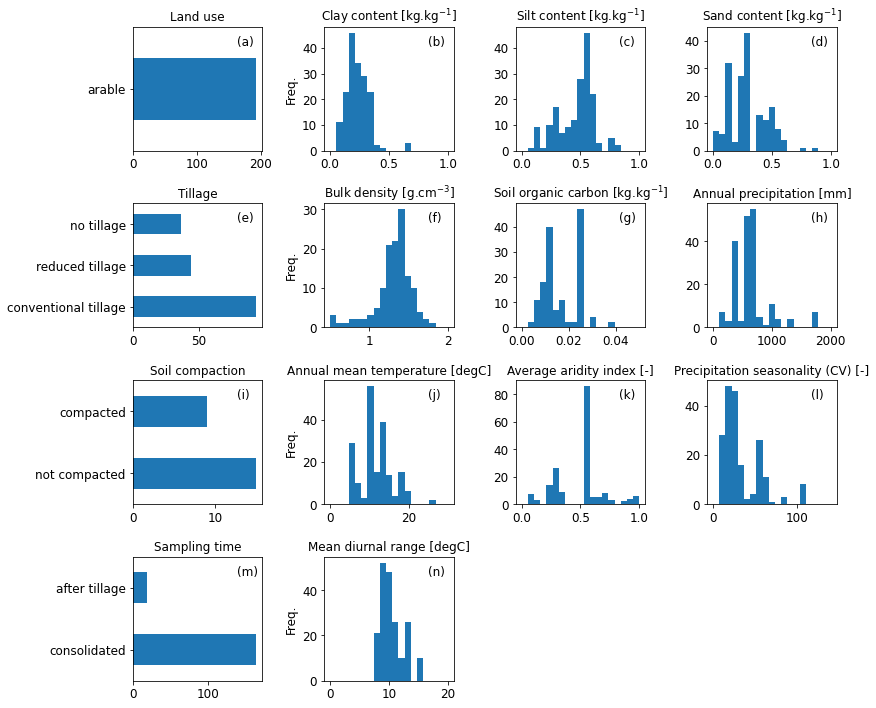

In [17]:
features = {
    'LanduseClass': ['Land use'],
    'ClayContent': ['Clay content [kg.kg$^{-1}$]', 0, 1],
    'SiltContent': ['Silt content [kg.kg$^{-1}$]', 0, 1],
    'SandContent': ['Sand content [kg.kg$^{-1}$]', 0, 1],
    'TillageClass': ['Tillage'],
    'BulkDensity': ['Bulk density [g.cm$^{-3}$]', 0.5, 2.0],
    'SoilOrganicCarbon': ['Soil organic carbon [kg.kg$^{-1}$]', 0, 0.05],
    'AnnualPrecipitation': ['Annual precipitation [mm]', 0, 2000],
    'CompactionClass': ['Soil compaction'],
    'AnnualMeanTemperature': ['Annual mean temperature [degC]', 0, 30],
    'AverageAridityIndex': ['Average aridity index [-]', 0, 1],
    'PrecipitationSeasonality': ['Precipitation seasonality (CV) [-]', 0, 140],  # coefficient of variation
    'SamplingTimeClass': ['Sampling time'],
    'MeanDiurnalRange': ['Mean diurnal range [degC]', 0, 20],
    #'NbOfCropRotation': ['Number of crop rotation'],
    #'ResidueClass': ['Residues'],
    #'GrazingClass': ['Grazing'],
    #'IrrigationClass': ['Irrigation'],

}

fig, axs = plt.subplots(4, 4, figsize=(12, 10))
axs = axs.flatten()
for i, key in enumerate(features):
    ax = axs[i]
    data = features[key]
    ax.set_title(data[0], fontsize=12)
    if len(data) > 1:
        ax.hist(dfm[i2keep][key], bins=np.linspace(data[1], data[2], 20))
    else:
        dfm[i2keep][key].replace({'unknown': np.nan,
                          -9999: np.nan,
                          0: np.nan} # for the 0 cover crops
                        ).dropna().value_counts().plot.barh(ax=ax)
    ax.annotate('(' + letters[i] + ')', (0.8, 0.85), xycoords='axes fraction')
    if i % 4 == 1:
        ax.set_ylabel('Freq.')
[axs[j].remove() for j in range(i+1, len(axs))]
fig.tight_layout()
fig.savefig(outputdir + 'eda-hist.jpg', dpi=500)

In [18]:
# table with features statistics
dffeat = pd.DataFrame([
    ['Soil', 'SandContent', 'Sand content', 'kg.kg-1', '-'],
    ['Soil', 'SiltContent', 'Silt content', 'kg.kg-1', '-'],
    ['Soil', 'ClayContent', 'Clay content', 'kg.kg-1', '-'],
    ['Soil', 'BulkDensity', 'Bulk density', 'g.cm-3', '-'],
    ['Soil', 'SoilOrganicCarbon', 'Soil organic carbon', 'kg.kg-1', '-'],
    ['Climate', 'AnnualMeanTemperature', 'Annual mean temperature', '°C', '-'],
    ['Climate', 'AnnualPrecipitation', 'Annual mean precipitation', 'mm', '-'],
    ['Climate', 'AverageAridityIndex', 'Average aridity index', '-', '-'],
    ['Climate', 'PrecipitationSeasonality', 'Precipitation seasonality (CV)', '-', '-'],
    ['Climate', 'MeanDiurnalRange', 'Mean diurnal range', 'degC', '-'],
    ['Management', 'LanduseClass', 'Land use', 'choices', ''],
    ['Management', 'TillageClass', 'Tillage', 'choices', ''],
    #['Management', 'NbOfCropRotation', 'Number of crop rotation', 'choices', ''],
    #['Management', 'ResidueClass', 'Residues', 'choices', ''],
    #['Management', 'GrazingClass', 'Grazing', 'choices', ''],
    #['Management', 'IrrigationClass', 'Irrigation', 'choices', ''],
    ['Management', 'CompactionClass', 'Soil compaction', 'choices', ''],
    ['Management', 'SamplingTimeClass', 'Sampling time', 'choices', '']
], columns=['Type', 'col', 'Predictor', 'Unit', 'Range/Choices'])
dffeat['Number of entries'] = 0
dffeat['Number of gaps'] = 0
for i in range(dffeat.shape[0]):
    col = dffeat.loc[i, 'col']
    s = dfm[col].replace(-9999, np.nan).replace('unknown', np.nan).replace(0, np.nan)
    s2 = dfm[i2keep][col].replace(-9999, np.nan).replace('unknown', np.nan).replace(0, np.nan)
    dffeat.loc[i, 'Number of entries'] = '{:d} ({:d})'.format(s2.notnull().sum(), s.notnull().sum())
    dffeat.loc[i, 'Number of gaps'] = '{:d} ({:d})'.format(s2.isna().sum(), s.isna().sum())
    if dffeat.loc[i, 'Range/Choices'] == '':
        choices = sorted(s.dropna().unique())
        if type(choices[0]) != str:
            choices = ['{:.0f}'.format(a) for a in choices]
        dffeat.loc[i, 'Range/Choices'] = ', '.join(choices)
    elif dffeat.loc[i, 'Range/Choices'] == '-':
        dffeat.loc[i, 'Range/Choices'] = '{:.1f} -> {:.1f} ({:.1f} -> {:.1f})'.format(
            s2.min(), s2.max(), s.min(), s.max())
    # mean and sd?
dffeat = dffeat.drop('col', axis=1)
dffeat.style.hide_index()

Type,Predictor,Unit,Range/Choices,Number of entries,Number of gaps
Soil,Sand content,kg.kg-1,0.0 -> 0.9 (0.0 -> 1.0),172 (1070),21 (215)
Soil,Silt content,kg.kg-1,0.1 -> 0.8 (0.0 -> 0.8),172 (1070),21 (215)
Soil,Clay content,kg.kg-1,0.1 -> 0.7 (0.0 -> 0.8),172 (1107),21 (178)
Soil,Bulk density,g.cm-3,0.5 -> 1.8 (0.1 -> 2.2),132 (771),61 (514)
Soil,Soil organic carbon,kg.kg-1,0.0 -> 0.0 (0.0 -> 1.0),146 (938),47 (347)
Climate,Annual mean temperature,°C,5.7 -> 26.8 (-3.8 -> 29.1),193 (1214),0 (71)
Climate,Annual mean precipitation,mm,190.0 -> 3183.0 (22.0 -> 3183.0),193 (1214),0 (71)
Climate,Average aridity index,-,0.1 -> 1.9 (0.0 -> 2.8),193 (1214),0 (71)
Climate,Precipitation seasonality (CV),-,9.9 -> 104.1 (9.6 -> 138.5),193 (1214),0 (71)
Climate,Mean diurnal range,degC,7.6 -> 15.6 (4.8 -> 18.5),193 (1214),0 (71)


## Apply the filtering

The following figures will use the filtered data averaged according to unique combination of land use, tillage, compaction and sampling time per reference. This approach is similar to the one used in the meta-analysis.

In [19]:
# creating weight (max weight per study = 1, weight inside study split according to replicates)
dfm['Reps'] = dfm['Reps'].fillna(1)
dfm['w_eda'] = np.nan
for ref in dfm['ReferenceTag'].unique():
    ie = dfm['ReferenceTag'].eq(ref)
    nbReplicates = dfm[ie]['Reps'].sum()
    dfm.loc[ie, 'w_eda'] = dfm[ie]['Reps']*1/np.sqrt(nbReplicates)

Formula for weighted average ($\bar x$) and standard error of weighted average ($s_{\bar x}$) weighted according to replicates.
$$\bar x = \frac{\sum_{i=1}^n x_i w_i}{\sum_{i=1}^n w_i}$$   and    $$s_{\bar x} = \sqrt{\frac{\sigma_x^2 \sum_{i=1}^n w_i^2}{(\sum_{i=1}^n w_i)^2}}$$


In [20]:
# aggregating function (weighted by w_eda which depends on number of reps)
def wmean(s):
    # weighted mean
    inan = s.notnull() & (s.abs() != np.inf)
    wi = dfm2.loc[s.index, 'w_eda']
    return (s * wi)[inan].sum()/wi[inan].sum()

def wsem(s):
    # standard error of weighted mean
    # http://www.analyticalgroup.com/download/WEIGHTED_MEAN.pdf
    inan = s.notnull() & (s.abs() != np.inf)
    wi = dfm2.loc[s.index, 'w_eda'][inan]
    varm = s[inan].var()*wi.pow(2).sum()/wi.sum()**2
    return np.sqrt(varm)

#dfg.agg(wsem)
#dfm2[dfm2['Tension range'].eq('[10 -  40]')][['ReferenceName', 'Ks', 'K10', 'K40']].groupby('ReferenceName').mean().sort_values('Ks', ascending=False)

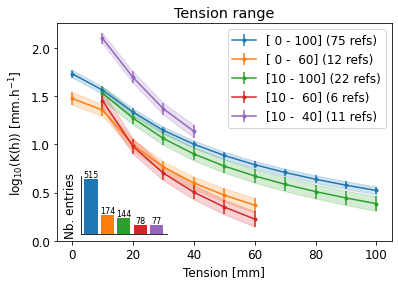

In [21]:
# plot the average curve per range
# evolution of K per tension per tillage
# NOTE: some NaN can remain because of the classes. For e.g. Tmin = 13, Tmax = 100 
# will be classified into the 10 - 100 but won't contain a K10 (10 mm tension) prediction as 
# prediction are only made between Tmin and Tmax.
gcol = 'Tension range'
dfm2 = dfm.copy()
def func(x):
    return np.round(x/10, 0)*10
dfm2['Tmin'] = dfm2['Tmin'].apply(func)
dfm2['Tmax'] = dfm2['Tmax'].apply(func)
dfm2.loc[dfm2['Tmax'].gt(100), 'Tmax'] = 100
dfm2['Tension range'] = np.nan
ranges = [[0, 100], [0, 60], [10, 100], [10, 60], [10, 40]]
labs = ['[{:2.0f} - {:3.0f}]'.format(a, b) for a, b in ranges]
for i, (a, b) in enumerate(ranges):
    dfm2.loc[dfm2['Tmin'].eq(a) & dfm2['Tmax'].eq(b), 'Tension range'] = labs[i]
dfg = dfm2.groupby(gcol)
dfmean = dfg.agg(wmean).reset_index()  # weighted
dfsem = dfg.agg(wsem).reset_index()
#dfmean = dfg.mean().reset_index() # unweighted
#dfsem = dfg.sem().reset_index()
dfcount = dfg.count().reset_index()
df = pd.merge(dfmean, dfsem, on=gcol, suffixes=('', '_sem'))
df = pd.merge(df, dfcount, on=gcol, suffixes=('', '_count'))
cols = ['log_' + a for a in kcols]
#cols = kcols
semcols = [a + '_sem' for a in cols]
fig, ax = plt.subplots()
for val in labs:
    nref = dfm2.loc[dfm2[gcol] == val, 'ReferenceTag'].unique().shape[0]
    ie = df[gcol] == val
    cax = ax.errorbar(np.arange(0, 11)*10, df[ie][cols].values.flatten(),
                yerr=df[ie][semcols].values.flatten(),
                marker='.', label=val + ' ({:d} refs)'.format(nref))
    ax.fill_between(np.arange(0, 11)*10,
                   df[ie][cols].values.flatten() - df[ie][semcols].values.flatten(),
                   df[ie][cols].values.flatten() + df[ie][semcols].values.flatten(),
                   alpha=0.2, color=cax.get_children()[0].get_color())
ax.legend()
#ax.set_yscale('log')
ax.set_title('Tension range')
ax.set_ylim([0, None])
ax.set_xlabel('Tension [mm]')
ax.set_ylabel('log$_{10}$(K(h)) [mm.h$^{-1}$]')
axh = fig.add_axes([0.18, 0.15, 0.2, 0.2])
for i, c in enumerate(labs):
    sc = dfm2[gcol].eq(c).sum()
    axh.bar(i, sc)
    axh.text(i, sc, '{:d}'.format(sc), ha='center', va='bottom', fontsize=8)
axh.grid(False)
axh.spines['top'].set_visible(False)
axh.spines['right'].set_visible(False)
axh.set_yticks([])
axh.set_xticks([])
axh.set_ylabel('Nb. entries')
axh.patch.set_alpha(0)  # transparent background

fig.savefig(outputdir + 'k-' + gcol + '.jpg', dpi=300)

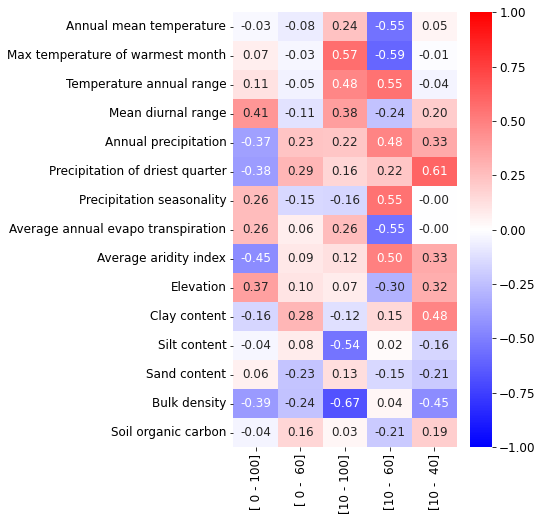

In [22]:
# are these differences correlated with other factors such as aridity index or others?
# not weighted correlated
variables = [
    'AnnualMeanTemperature',             
    'MaxTemperatureofWarmestMonth',
    'TemperatureAnnualRange',
    'MeanDiurnalRange',  
    'AnnualPrecipitation',
    'PrecipitationofDriestQuarter',
    'PrecipitationSeasonality',
    'AverageAnnualEvapoTranspiration',
    'AverageAridityIndex',
    'Elevation',
    'ClayContent',
    'SiltContent',
    'SandContent',
    'BulkDensity',
    'SoilOrganicCarbon'
]

def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    groups = [m.group(0) for m in matches]
    gs = []
    for a in groups:
        if a[-2:] == 'of':
            gs.append(a[:-2])
            gs.append('of')
        else:
            gs.append(a)
    return ' '.join(gs).capitalize()

dfcorr = pd.DataFrame(columns=variables)
dfcorr['range'] = labs

for i, val in enumerate(labs):  # for each measurement range
    ie = dfm2[gcol].eq(val)
    # compute correlation to pedo-climatic variables
    for variable in variables:
        x = dfm2[ie]['K30'].values
        # NOTE we choose K3 as it's a common value for all ranges (K10 is only know for some ranges)
        y = dfm2[ie][variable].values
        inan = ~np.isnan(y) & ~np.isnan(x)
        corr, pval = stats.spearmanr(x[inan], y[inan])
        dfcorr.loc[i, variable] = corr

fig, ax = plt.subplots(figsize=(5, 8))
sns.heatmap(dfcorr[dfcorr.columns[:-1]].T.fillna(0),
            vmin=-1, vmax=1, cmap='bwr', ax=ax,
            annot=True, fmt='1.2f',
            yticklabels=[camel_case_split(a) for a in variables])
ax.set_xticklabels(labs, rotation=90);

In [23]:
# apply filtering (run ONCE)
dfm = dfm[i2keep].reset_index(drop=True)

In [24]:
# updating weight (max weight per study = 1, weight inside study split according to replicates)
dfm['Reps'] = dfm['Reps'].fillna(1)
dfm['w_eda'] = np.nan
for ref in dfm['ReferenceTag'].unique():
    ie = dfm['ReferenceTag'].eq(ref)
    nbReplicates = dfm[ie]['Reps'].sum()
    dfm.loc[ie, 'w_eda'] = dfm[ie]['Reps']*1/np.sqrt(nbReplicates)

In [25]:
#create column with absolute latitude 
dfm['AbsLatitude'] = dfm['Latitude'].abs()

## Correlation

### Continuous numerical variables

In [26]:
# correlation matrix with all variables
#xlabs = ['log_' + a for a in kcols]
#ie = pd.Series(factors + xlabs).isin(dfm.columns.tolist())
#dfcorr = dfm[np.array(factors + xlabs)[ie]].corr(method='pearson')
#fig, ax = plt.subplots(figsize=(14, 10))
#sns.heatmap(dfcorr.values, ax=ax, cmap='bwr', xticklabels=dfcorr.columns.values,
#            yticklabels=dfcorr.columns.values, vmin=-1, vmax=1,
#            cbar_kws={'label': 'Spearman Rank Correlation'})
#fig.savefig(outputdir + 'K-correlation.jpg', dpi=500)

In [27]:
# useful function for weighted rank correlation
def _weightedRankMean(sdf):
    """Weighted Mean"""
    dfr = sdf[cols].rank().reset_index()
    dfwm = (dfr[cols].mul(sdf['w_eda'], axis=0)).sum()/sdf['w_eda'].sum()
    return dfwm

def _weightedMean(x, w):
    """Weighted Mean"""
    return np.sum(x * w) / np.sum(w)

def _weightedCov(x, y, w):
    """Weighted Covariance"""
    return np.sum(w * (x - _weightedMean(x, w)) * (y - _weightedMean(y, w))) / np.sum(w)

def _weightedCorr(ic, jc, w):
    myWCov = _weightedCov(ic, jc, w)
    myWSd1 = _weightedCov(ic, ic, w)
    myWSd2 = _weightedCov(jc, jc, w)
    myWCorr  = myWCov / np.sqrt(myWSd1 * myWSd2)
    return myWCorr

def _weightedRankCorr(sdf, weight):
    """Weighted Covariance"""

    min_periods = 1
    dfr = sdf.rank()   
    K = sdf.shape[1]
    myWCorr = np.zeros((K, K), dtype=float)
    mask = np.isfinite(dfr)

    w = weight

    for i, ic in enumerate(dfr.columns):
        for j, jc in enumerate(dfr.columns):

            x = dfr[ic]
            y = dfr[jc]

            myWCorr[i, j] = _weightedCorr(x, y, w)
            
    wCorr = pd.DataFrame(data=myWCorr, index=sdf.columns, columns=sdf.columns)

    return wCorr

def _calcConfidence4WeightedRankCorr(dfr, myWeightedCorr, randomizos):
    
    #the confidence interval is calculated based on a randomization test. the latter creates a PDF of correlations expected for the data with expected value of 0. See also permutation test on wikipedia    
    K = dfr.shape[1]
    myConfCount = np.zeros((K-1, K-1), dtype=float)   
        
    #calculate rank correlation test    
    for k in range(randomizos):
                  
        #create dataframe 1 and 2 with randomized rows
        dfs1 = shuffle(dfr).reset_index(drop=True)        
        dfs2 = shuffle(dfr).reset_index(drop=True)        
    
        w = (dfs1['w_eda'] + dfs2['w_eda']) / 2
        dfs1 = dfs1.drop(columns = ['w_eda'])
        dfs2 = dfs2.drop(columns = ['w_eda'])
        
        for i, ic in enumerate(dfs1.columns):
            for j, jc in enumerate(dfs2.columns):

                x = dfs1[ic]
                y = dfs2[jc]

                if abs(_weightedCorr(x, y, w)) > abs(myWeightedCorr.iloc[i,j]):
                    myConfCount[i,j] = myConfCount[i,j] + 1        
                    
    pvals = myConfCount / randomizos 
    
    dfout = pd.DataFrame(data=pvals, index=dfs1.columns, columns=dfs2.columns)

    return dfout



def camel_case_split(identifier):
    matches = re.finditer('.+?(?:(?<=[a-z])(?=[A-Z])|(?<=[A-Z])(?=[A-Z][a-z])|$)', identifier)
    groups = [m.group(0) for m in matches]
    gs = []
    for a in groups:
        if a[-2:] == 'of':
            gs.append(a[:-2])
            gs.append('of')
        else:
            gs.append(a)
    return ' '.join(gs).capitalize()

def shadepval(dfm, dfcorr, pval=pval, randomizos=randomizos):
    """Compute weighted pvalue for Spearman rank correlation.
    
    Parameters
    ----------
    dfm2 : pandas.DataFrame
        Initial dataframe with raw data for selected columns.
    dfcorr : pandas.DataFrame
        Correlation matrix corresponding.
    pval : float, optional
        p-value threshold under with the correlationg is considered significant.
    randomizos : int, optional
        Number of randomized realization of dataframe to calculate the significance level.
        
    Returns
    -------
    dflab : pandas.DataFrame
        Dataframe similar to dfcorr but all dtypes as string. Non-significant results are empty strings.
    dfpval : pandas.DataFrame
        Dataframe with computed p-values.
    """
    # compute pvalue and text to put on cell (if pvalue < threshold)
    #number of randomized realizations of dataframe to calculate the significance level
    dfpval = _calcConfidence4WeightedRankCorr(dfm, dfcorr, randomizos)  #calculate significance  .. takes a loooooong time
    corr = dfcorr.copy().values
    corr[dfpval.values > pval] = np.nan  # shading all corr that are below pval
    def func(x):
        if pd.isna(x):
            return ''
        else:
            return '{:0.2f}'.format(x)
    dflab = pd.DataFrame(corr, columns=dfpval.columns)
    for col in dflab.columns:
        dflab[col] = dflab[col].apply(func)
    return dflab, dfpval

array(['Steady-state piecewise'], dtype=object)

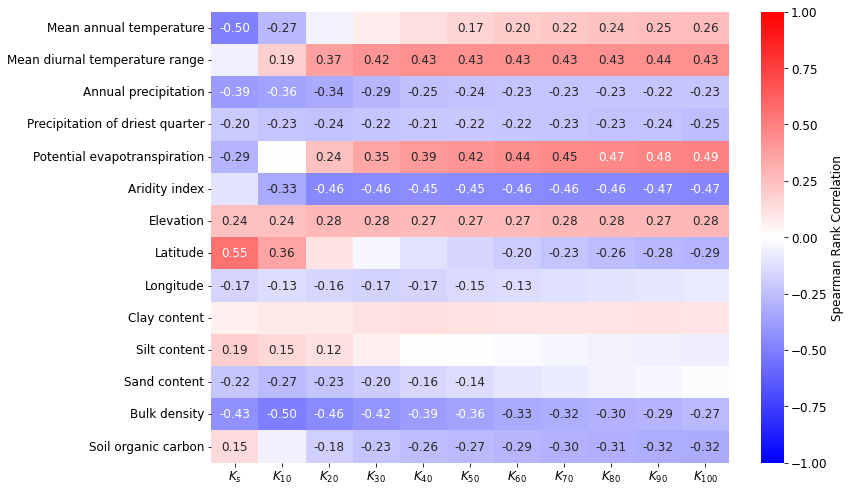

In [28]:
# just for climatic variables

# define columns names and associated labels
gdic = {
    'AnnualMeanTemperature': 'Mean annual temperature',             
    'MeanTemperatureofWarmestQuarter': 'Mean temperatue of warmest quarter',
    'MaxTemperatureofWarmestMonth': 'Max temperature of warmest month',
    'MeanTemperatureofColdestQuarter': 'Mean temperature of coldest quarter',
    'MinTemperatureofColdestMonth': 'Minimum temperature of coldest month',
    'MeanTemperatureofWettestQuarter': 'Mean temperature of wettest quarter',
    'MeanTemperatureofDriestQuarter': 'Mean temperature of driest quarter',
    'TemperatureSeasonality': 'Temperature seasonality',
    'TemperatureAnnualRange': 'Temperature annual range',
    'MeanDiurnalRange': 'Mean diurnal temperature range',
    'Isothermality': 'Isothermality',
    'AnnualPrecipitation': 'Annual precipitation',
    'PrecipitationofWarmestQuarter': 'Precipitation of warmest quarter',
    'PrecipitationofColdestQuarter': 'Precipitation of coldest quarter',
    'PrecipitationofWettestQuarter': 'Precipitation of wettest quarter',
    'PrecipitationofWettestMonth': 'Precipitation of wettest month',
    'PrecipitationofDriestQuarter': 'Precipitation of driest quarter',
    'PrecipitationofDriestMonth': 'Precipitation of driest month',
    'PrecipitationSeasonality': 'Precipitation seasonality',
    'AverageAnnualEvapoTranspiration': 'Potential evapotranspiration',
    'AverageAridityIndex': 'Aridity index',
    'Elevation': 'Elevation',
    'AbsLatitude': 'Latitude',
    'Longitude': 'Longitude',
    'ClayContent': 'Clay content',
    'SiltContent': 'Silt content',
    'SandContent': 'Sand content',
    'BulkDensity': 'Bulk density',
    'SoilOrganicCarbon': 'Soil organic carbon',
    'log_Ks': '$K_s$',
    'log_K10': '$K_{10}$',
    'log_K20': '$K_{20}$',
    'log_K30': '$K_{30}$',
    'log_K40': '$K_{40}$',
    'log_K50': '$K_{50}$',
    'log_K60': '$K_{60}$',
    'log_K70': '$K_{70}$',
    'log_K80': '$K_{80}$',
    'log_K90': '$K_{90}$',
    'log_K100': '$K_{100}$',
}
def getLabel(x):
    if x in gdic:
        return gdic[x]
    else:
        return camel_case_split(x)
    

def showCorr(dfm, xcols, ycols, ax=None, method='spearman', cmap='bwr',
             weighted=True, pshadow=True, pval=pval, randomizos=randomizos):
    """Display correlation matrix.
    """
    # make a copy of the dataframe (for safety)
    dfm2 = dfm.copy()
    
    # which label
    if method == 'spearman':
        label = 'Spearman Rank Correlation'
    elif method == 'pearson':
        label = 'Pearson Correlation'
    else:
        label = ''
    
    # create correlation matrix      
    cols = (ycols + xcols)    
    if xcols == ycols:
        cols = ycols  
    if weighted:
        if method == 'spearman':
            dfcorr = _weightedRankCorr(dfm2[cols], dfm2['w_eda'])
        else:
            print('only method "spearman" is avaible with weighting')
            return
    else:
        dfcorr = dfm2[cols].corr(method=method)

    # create subset of correlation matrix
    ivar = np.zeros(dfcorr.shape[0], dtype=bool)
    ivar[:len(ycols)] = True
    
    # compute pvalues
    if pshadow:
        dflab, dfpval = shadepval(dfm2[cols + ['w_eda']],
                                  dfcorr, pval=pval, randomizos=randomizos)

    # figure
    flag = False
    if ax is None:
        fig, ax = plt.subplots()
        flag = True
        
    # if we have square matrix then we only show the lower triangle
    if np.in1d(np.array(xcols), np.array(ycols)).all():
        mask = np.zeros((ivar.sum(), len(xcols)), dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = np.zeros((ivar.sum(), len(xcols)), dtype=bool)

    sns.heatmap(dfcorr[ivar][xcols].values, mask=mask, ax=ax, cmap=cmap,
                yticklabels=[getLabel(a) for a in ycols],
                xticklabels=[getLabel(a) for a in xcols],
                vmin=-1, vmax=1, annot=dflab[ivar][xcols].values, fmt='s',
                cbar_kws={'label': label})
    if flag:
        return fig

xcols = ['log_Ks', 'log_K10', 'log_K20', 'log_K30', 'log_K40', 'log_K50',
         'log_K60', 'log_K70', 'log_K80', 'log_K90', 'log_K100']
ycols = [
    'AnnualMeanTemperature',             
    #'MeanTemperatureofWarmestQuarter',
    #'MaxTemperatureofWarmestMonth',
    #'MeanTemperatureofColdestQuarter',
    #'MinTemperatureofColdestMonth',
    #'MeanTemperatureofWettestQuarter',
    #'MeanTemperatureofDriestQuarter',
    #'TemperatureSeasonality',
    #'TemperatureAnnualRange',
    'MeanDiurnalRange',
    #'Isothermality',
    'AnnualPrecipitation',
    #'PrecipitationofWarmestQuarter',
    #'PrecipitationofColdestQuarter',
    #'PrecipitationofWettestQuarter',
    #'PrecipitationofWettestMonth',
    'PrecipitationofDriestQuarter',
    #'PrecipitationofDriestMonth',
    #'PrecipitationSeasonality',
    'AverageAnnualEvapoTranspiration',
    'AverageAridityIndex',
    'Elevation',
    'AbsLatitude',
    'Longitude',
    'ClayContent',
    'SiltContent',
    'SandContent', 
    'BulkDensity',
    'SoilOrganicCarbon'
]

fig, ax = plt.subplots(figsize=(10, 7))
showCorr(dfm, xcols, ycols, ax=ax, pshadow=True, pval=pval, randomizos=randomizos)
fig.tight_layout()
fig.subplots_adjust(right=1.2)
fig.savefig(outputdir + 'eda-correlation-climate.jpg', dpi=500, bbox_inches='tight')
dfm['Method'].unique()

In [29]:
# xcols = ['log_Ks', 'log_K10', 'log_K20', 'log_K30', 'log_K40', 'log_K50',
#          'log_K60', 'log_K70', 'log_K80', 'log_K90', 'log_K100']
# ycols = [
#     #'AnnualMeanTemperature',             
#     #'MeanTemperatureofWarmestQuarter',
#     #'MaxTemperatureofWarmestMonth',
#     #'MeanTemperatureofColdestQuarter',
#     #'MinTemperatureofColdestMonth',
#     #'MeanTemperatureofWettestQuarter',
#     #'MeanTemperatureofDriestQuarter',
#     #'TemperatureSeasonality',
#     #'TemperatureAnnualRange',
#     #'MeanDiurnalRange',
#     #'Isothermality',
#     #'AnnualPrecipitation',
#     #'PrecipitationofWarmestQuarter',
#     #'PrecipitationofColdestQuarter',
#     #'PrecipitationofWettestQuarter',
#     #'PrecipitationofWettestMonth',
#     #'PrecipitationofDriestQuarter',
#     #'PrecipitationofDriestMonth',
#     #'PrecipitationSeasonality',
#     #'AverageAnnualEvapoTranspiration',
#     #'AverageAridityIndex',
#     #'Elevation',
#     'AbsLatitude',
#     'Longitude',
#     'ClayContent',
#     'SiltContent',
#     'SandContent',
#     #'FineTextured',
#     #'MediumTextured',
#     #'CoarseTextured',
#     #'BulkDensity',
#     #'SoilOrganicCarbon',
#     #'LandUseArable',
#     #'LandUseGrassland',
#     #'LandUseForestOrPlantation',
#     #'Compacted',
#     #'FreshlyTilled',
#     #'Sequence dry to wet',
#     #'Sequence wet to dry',
#     #'Method s-s. piecewise',
#     #'Method s-s. constant'  
#     #'ConventionalTillage',
#     #'ReducedTillage',
#     #'NoTillage',
#     #'Method s-s. multi-disk',
#     #'Method transient'
    
# ]

# fig, ax = plt.subplots(figsize=(8, 4))
# showCorr(dfm, xcols, ycols, ax=ax, pshadow=True, pval=pval, randomizos=randomizos)
# fig.tight_layout()
# fig.subplots_adjust(right=1.2)
# fig.savefig(outputdir + 'eda-correlation-rest.jpg', dpi=500, bbox_inches='tight')

In [30]:
# calculate significance (takes a while!)
# randomizos = 50  #number of randomized realizations of dataframe to calculate the significance level
# pvalue = _calcConfidence4WeightedRankCorr(dfm2[variables + xlabs + ['w_eda']], dfcorr, randomizos)  #calculate significance  .. take a loooooong time

# fig, ax = plt.subplots(figsize=(12, 9))
# sns.set(font_scale = 1.8)
# sns.heatmap(pvalue[ivar][xlabs].values, ax=ax, cmap='bwr',
#             yticklabels=[camel_case_split(a) for a in vnames],
#             xticklabels=knames, vmin=0, vmax=1, annot=True, fmt='1.2f',
#             annot_kws={"size": 14},
#             cbar_kws={'label': 'p-value for Spearman Rank Correlation'})
# fig.tight_layout()
# fig.subplots_adjust(right=1.2)
# fig.savefig(outputdir + 'eda-correlation-climate-pvalues_n' + str(randomizos) + '.jpg', dpi=500, bbox_inches='tight')

In [31]:
#xcols = ['log_Ks', 'log_K1', 'log_K2', 'log_K3', 'log_K4', 'log_K5',
#         'log_K6', 'log_K7', 'log_K8', 'log_K9', 'log_K10']
#ycols = [
#    'ClayContent',
#    'SiltContent',
#    'SandContent',
#    'BulkDensity',
#    'SoilOrganicCarbon'
#]

#fig, ax = plt.subplots(figsize=(8, 4))
#showCorr(dfm, xcols, ycols, ax=ax, pshadow=True, pval=pval, randomizos=25)
#fig.tight_layout()
#fig.subplots_adjust(right=1.2)
#fig.savefig(outputdir + 'eda-correlation-soil-k.jpg', dpi=500, bbox_inches='tight')

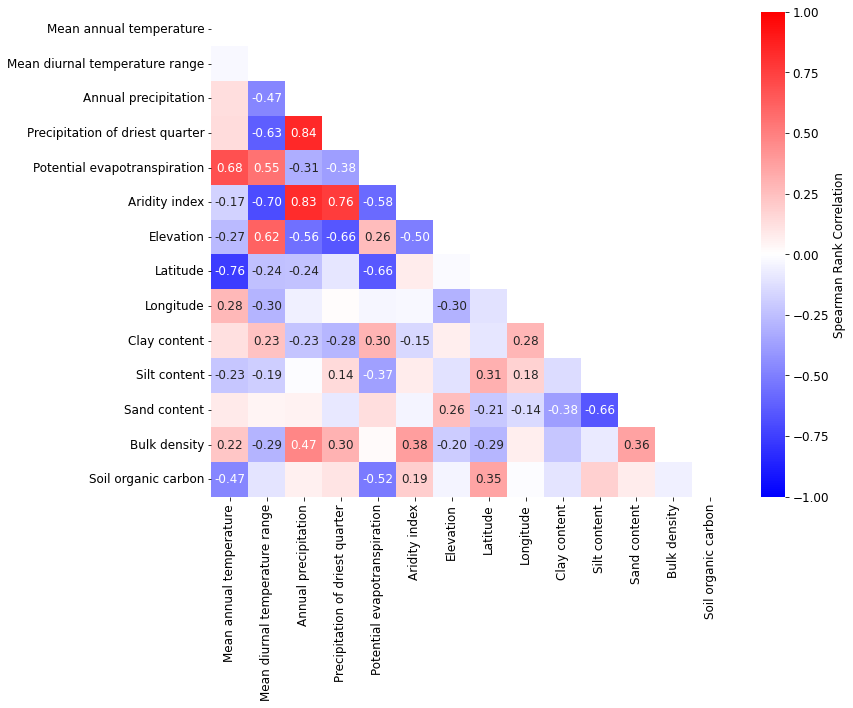

In [32]:
# just for climatic variables
ycols = [
    'AnnualMeanTemperature',             
    #'MeanTemperatureofWarmestQuarter',
    #'MaxTemperatureofWarmestMonth',
    #'MeanTemperatureofColdestQuarter',
    #'MinTemperatureofColdestMonth',
    #'MeanTemperatureofWettestQuarter',
    #'MeanTemperatureofDriestQuarter',
    #'TemperatureSeasonality',
    #'TemperatureAnnualRange',
    'MeanDiurnalRange',
    #'Isothermality',
    'AnnualPrecipitation',
    #'PrecipitationofWarmestQuarter',
    #'PrecipitationofColdestQuarter',
    #'PrecipitationofWettestQuarter',
    #'PrecipitationofWettestMonth',
    'PrecipitationofDriestQuarter',
    #'PrecipitationofDriestMonth',
    #'PrecipitationSeasonality',
    'AverageAnnualEvapoTranspiration',
    'AverageAridityIndex',
    'Elevation',
    'AbsLatitude',
    'Longitude',
    'ClayContent',
    'SiltContent',
    'SandContent',
    'BulkDensity',
    'SoilOrganicCarbon'
]
    

fig, ax = plt.subplots(figsize=(12, 10))
showCorr(dfm, ycols, ycols, ax=ax, pshadow=True, pval=pval, randomizos=randomizos)
fig.tight_layout()
fig.subplots_adjust(right=1)
fig.savefig(outputdir + 'eda-correlation-climclim.jpg', dpi=500, bbox_inches='tight')

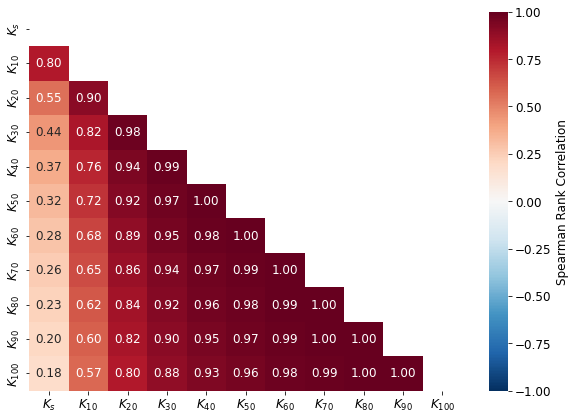

In [33]:
# K self-correlation.
xcols = ['log_Ks', 'log_K10', 'log_K20', 'log_K30', 'log_K40', 'log_K50',
         'log_K60', 'log_K70', 'log_K80', 'log_K90', 'log_K100']

fig, ax = plt.subplots(figsize=(8, 6))
showCorr(dfm, xcols, xcols, ax=ax, cmap = 'RdBu_r', pshadow=True, pval=pval, randomizos=randomizos)
fig.tight_layout()
fig.subplots_adjust(right=1)
fig.savefig(outputdir + 'eda-correlation-KnK.jpg', dpi=500, bbox_inches='tight')

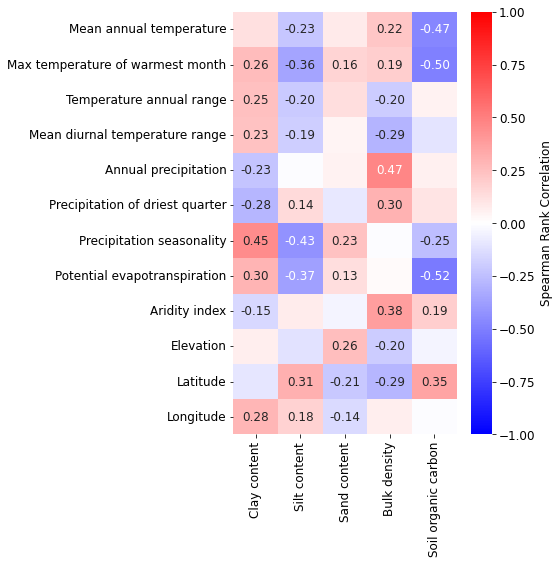

In [34]:
# just for climatic variables
xcols = [
    'ClayContent',
    'SiltContent',
    'SandContent',
    'BulkDensity',
    'SoilOrganicCarbon'
]

ycols = [
    'AnnualMeanTemperature',             
    #'MeanTemperatureofWarmestQuarter',
    'MaxTemperatureofWarmestMonth',
    #'MeanTemperatureofColdestQuarter',
    #'MinTemperatureofColdestMonth',
    #'MeanTemperatureofWettestQuarter',
    #'MeanTemperatureofDriestQuarter',
    #'TemperatureSeasonality',
    'TemperatureAnnualRange',
    'MeanDiurnalRange',  
    #'Isothermality',           
    'AnnualPrecipitation',
    #'PrecipitationofWarmestQuarter',
    #'PrecipitationofColdestQuarter',
    #'PrecipitationofWettestQuarter',
    #'PrecipitationofWettestMonth',
    'PrecipitationofDriestQuarter',
    #'PrecipitationofDriestMonth',
    'PrecipitationSeasonality',
    'AverageAnnualEvapoTranspiration',
    'AverageAridityIndex',
    'Elevation',
    'AbsLatitude',
    'Longitude'
]

# figure
fig, ax = plt.subplots(figsize=(8, 8))
showCorr(dfm, xcols, ycols, ax=ax, pshadow=True, pval=pval, randomizos=randomizos)           
fig.tight_layout()
fig.subplots_adjust(right=0.9)
fig.savefig(outputdir + 'eda-correlation-soilclimate.jpg', dpi=500, bbox_inches='tight')

### Categorical variables

IndexError: single positional indexer is out-of-bounds

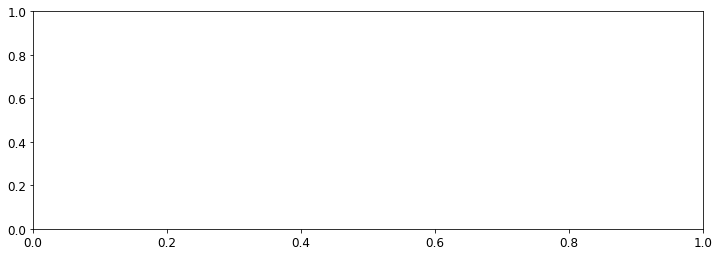

In [35]:
def _calcRankBiserialCorr(sdf, binaries, xcols):
    
    #rank continuous variables
    dfr = sdf.rank()
    
    #pick out binary variables
    binars = sdf[binaries]
    
    k = dfr[xcols]
    w = sdf['w_eda']
    biseriOut = np.zeros((binars.shape[1], k.shape[1]), dtype=float)
    reppedW = pd.concat([w] * len(xcols), axis=1, ignore_index=True)
    reppedW.columns = xcols
    wK = k * reppedW
    sumWeightedK = wK.sum()

    for i, ic in enumerate(binaries):
        ndf = wK.groupby(binars[ic])
        sumZero2Ones = ndf.sum().reset_index()
        ww = reppedW.groupby(binars[ic])
        sumGroupedW = ww.sum().reset_index()
        countGroupedW = ww.count().reset_index()
        nmulti = ((countGroupedW[xcols].iloc[1] * countGroupedW[xcols].iloc[0]) / ((countGroupedW[xcols].iloc[1] + countGroupedW[xcols].iloc[0])**2))**0.5
        meanNDF = sumZero2Ones[xcols] / sumGroupedW[xcols]
        sd = _weightedCov(k, k, reppedW)**(1/2)
        #biseri = (meanNDF[xcols].iloc[1]-meanNDF[xcols].iloc[0]) / sd * nmulti
        biseri = 2 * (meanNDF[xcols].iloc[1]-meanNDF[xcols].iloc[0]) / (sumGroupedW[xcols].iloc[1]+sumGroupedW[xcols].iloc[0])
        biseriOut[i] = biseri.tolist()

    bidf = pd.DataFrame(data = biseriOut, index = binaries, columns = xcols)
    
    return bidf

def _calcConfidence4WeightedBiserialRankCorr(sdf, binaries, xcols, myBiSerialCorr, randomizos):
    
    #the confidence interval is calculated based on a randomization test. the latter creates a PDF of correlations expected for the data with expected value of 0. See also permutation test on wikipedia    
    xshape = sdf[xcols].shape[1]
    bshape = sdf[binaries].shape[1]
    myConfCount = np.zeros((bshape, xshape), dtype=float)
    biseri = np.zeros((bshape, xshape), dtype=float)
    maxbiseri = np.zeros((bshape, xshape), dtype=float)
        
    #calculate rank correlation test    
    for k in range(randomizos):
                  
        #create dataframe 1 and 2 with randomized rows
        dfs1 = shuffle(sdf).reset_index(drop=True)
        dfs2 = shuffle(sdf).reset_index(drop=True)    
       
        #calc mutual weight
        w = (dfs1['w_eda'] + dfs2['w_eda']) / 2
        dfs1 = dfs1.drop(columns = ['w_eda'])
        dfs2 = dfs2.drop(columns = ['w_eda'])
      
        #pick binary variables
        binars = dfs1[binaries]     
        xs = dfs2[xcols].rank()
        
        for i, ic in enumerate(binars.columns):
            for j, jc in enumerate(xs.columns):

                x = xs[jc]               
                
                wK = x * w
                wK.columns = ['wk']
                             
                ndf = wK.groupby(binars[ic])
                ww = w.groupby(binars[ic])
                
                sumZero2Ones = ndf.sum().reset_index()
                sumZero2Ones.columns = ['binar', 'sums']
                sumGroupedW = ww.sum().reset_index()    
                
                meanNDF = sumZero2Ones['sums'] / sumGroupedW['w_eda']         
                
                biseri[i,j] = 2 * (meanNDF.iloc[1]-meanNDF.iloc[0]) / (sumGroupedW['w_eda'].iloc[1]+sumGroupedW['w_eda'].iloc[0])

                if abs(biseri[i,j]) > abs(myBiSerialCorr.iloc[i,j]):
                    myConfCount[i,j] = myConfCount[i,j] + 1     
                     
    pvals = myConfCount / randomizos 

    dfout = pd.DataFrame(data=pvals, index=binars.columns, columns=xs.columns)

    return dfout

def showCorrBiserial(sdf, xcols, binaries, ax=None, cmap='bwr',
             pshadow=True, pval=pval, randomizos=randomizos):
    """Display correlation matrix.
    """
    # make a copy of the dataframe (for safety)
    dfm2 = sdf.copy()
    
    # which label
    label = 'Biserial Rank Correlation'
    
    # create correlation matrix      
    cols = (ycols + xcols)    
    
    #calculate the biserial rank correlation coefficient
    dfcorr = _calcRankBiserialCorr(dfm2, binaries, xcols)

    # create subset of correlation matrix
    ivar = np.zeros(dfcorr.shape[0], dtype=bool)
    ivar[:len(ycols)] = True
    
    # compute pvalues
    if pshadow:
        dflab, dfpval = shadepvalBiserial(sdf, binaries, xcols, dfcorr, pval=pval, randomizos=randomizos)

    # figure
    flag = False
    if ax is None:
        fig, ax = plt.subplots()
        flag = True
        
    # if we have square matrix then we only show the lower triangle
    if np.in1d(np.array(xcols), np.array(ycols)).all():
        mask = np.zeros((ivar.sum(), len(xcols)), dtype=bool)
        mask[np.triu_indices_from(mask)] = True
    else:
        mask = np.zeros((ivar.sum(), len(xcols)), dtype=bool)

    sns.heatmap(dfcorr[ivar][xcols].values, mask=mask, ax=ax, cmap=cmap,
                yticklabels=[getLabel(a) for a in binaries],
                xticklabels=[getLabel(a) for a in xcols],
                vmin=-1, vmax=1, annot=dflab[ivar][xcols].values, fmt='s',
                cbar_kws={'label': label})
    if flag:
        return fig

def shadepvalBiserial(sdf, binaries, xcols, dfcorr, pval=pval, randomizos=randomizos):
    """Compute weighted pvalue for Spearman rank correlation.
    
    Parameters
    ----------
    dfm2 : pandas.DataFrame
        Initial dataframe with raw data for selected columns.
    dfcorr : pandas.DataFrame
        Correlation matrix corresponding.
    pval : float, optional
        p-value threshold under with the correlationg is considered significant.
    randomizos : int, optional
        Number of randomized realization of dataframe to calculate the significance level.
        
    Returns
    -------
    dflab : pandas.DataFrame
        Dataframe similar to dfcorr but all dtypes as string. Non-significant results are empty strings.
    dfpval : pandas.DataFrame
        Dataframe with computed p-values.
    """
    # compute pvalue and text to put on cell (if pvalue < threshold)
    #number of randomized realizations of dataframe to calculate the significance level
    dfpval = _calcConfidence4WeightedBiserialRankCorr(sdf, binaries, xcols, dfcorr, randomizos)  #calculate significance  .. takes a loooooong time
    corr = dfcorr.copy().values
    corr[dfpval.values > pval] = np.nan  # shading all corr that are below pval
    def func(x):
        if pd.isna(x):
            return ''
        else:
            return '{:0.2f}'.format(x)
    dflab = pd.DataFrame(corr, columns=dfpval.columns)
    for col in dflab.columns:
        dflab[col] = dflab[col].apply(func)
    return dflab, dfpval


# test biserial correlation (for binary variables)
sdf = dfm.copy().replace({'unknown': np.nan})

ohLU = sdf['LanduseClass']
sdf['LandUseArable'] = ohLU == 'arable'
sdf['LandUseGrassland'] = ohLU == 'grassland'
sdf['LandUseForest'] = ohLU == 'woodland/plantation'
ohLU = sdf['TillageClass']
sdf['ConventionalTillage'] = ohLU == 'conventional tillage'
sdf['ReducedTillage'] = ohLU == 'reduced tillage'
sdf['NoTillage'] = ohLU == 'no tillage' 
ohLU = sdf['CompactionClass']
sdf['Compacted'] = ohLU == 'compacted'
ohLU = sdf['SamplingTimeClass']
sdf['FreshlyTilled'] = ohLU == 'after tillage'

gcol = 'SoilTextureUSDA'
def func(x):
    dico = {
        # np.nan: np.nan,
        # 'organic': np.nan,
        # 'clay': 'clay',
        # 'clay loam': 'loam',
        # 'loam': 'loam',
        # 'loamy sand': 'sand',
        # 'sand': 'sand',
        # 'sandy clay': 'clay',
        # 'sandy clay loam': 'loam',
        # 'sandy loam': 'loam',
        # 'silt loam': 'loam',
        # 'silty clay': 'loam',
        # 'silty clay loam': 'loam'
        np.nan: np.nan,
        'organic': np.nan,
        'clay': 'fine',
        'clay loam': 'fine',
        'loam': 'medium',
        'loamy sand': 'coarse',
        'sand': 'coarse',
        'sandy clay': 'coarse',
        'sandy clay loam': 'coarse',
        'sandy loam': 'coarse',
        'silt loam': 'medium',
        'silty clay': 'fine',
        'silty clay loam': 'fine'
    }
    return dico[x]
ohlu = sdf[gcol].apply(func)
sdf['FineTextured'] = ohlu == 'fine'
sdf['MediumTextured'] = ohlu == 'medium'
sdf['CoarseTextured'] = ohlu == 'coarse'

gcol = 'Method'
def func(x):
    dico = {
        np.nan: np.nan,
        'Steady-state constant': 'S-S. constant',
        'Steady-state piecewise': 'S-S. piecewise',
        'Steady-state multi-disc': 'S-S. multi-disk',
        'Steady-state constant  regression': 'S-S. constant',
        'Steady-state piecewise': 'S-S. piecewise',
        'Transient': 'Transient',
        'Other': np.nan,
        'Steady-state  multi-disc': 'S-S. multi-disc',
        '1D column': np.nan,
        np.nan: np.nan,
       'DISC software': np.nan,
       'steady-state constant regression': 'S-S. constant',
       'unclear - reference method': np.nan
    }
    return dico[x]

ohLU = sdf[gcol].apply(func)
sdf['Method s-s. piecewise'] = ohLU == 'S-S. piecewise'
sdf['Method s-s. constant'] = ohLU == 'S-S. constant'
sdf['Method s-s. multi-disk'] = ohLU == 'S-S. multi-disk'
sdf['Method transient'] = ohLU == 'Transient'

ohLU = sdf['Direction']
sdf['Sequence dry to wet'] = ohLU == 'Dry to wet'
sdf['Sequence wet to dry'] = ohLU == 'Wet to dry'

#define X-axis for correlation matrix
xcols = ['log_Ks', 'log_K10', 'log_K20', 'log_K30', 'log_K40', 'log_K50',
         'log_K60', 'log_K70', 'log_K80', 'log_K90', 'log_K100']

#plot it for land use, management and texture class
binaries = ['LandUseArable', 'LandUseGrassland', 'LandUseForest', 'ConventionalTillage', 'ReducedTillage', 'NoTillage', 'Compacted', 'FreshlyTilled', 'FineTextured', 'MediumTextured', 'CoarseTextured']
#binaries = ['ConventionalTillage', 'ReducedTillage', 'NoTillage', 'Compacted', 'FreshlyTilled', 'FineTextured', 'MediumTextured', 'CoarseTextured']
fig, ax = plt.subplots(figsize=(12, 4))
showCorrBiserial(sdf, xcols, binaries, ax=ax, cmap = 'bwr', pshadow=True, pval=pval, randomizos=randomizos)
fig.tight_layout()
fig.subplots_adjust(right=1)
fig.savefig(outputdir + 'biserial_LUnTex.jpg', dpi=500, bbox_inches='tight')

#plot it for method variations
binaries = ['Method s-s. piecewise', 'Method s-s. constant', 'Method transient', 'Sequence dry to wet', 'Sequence wet to dry']
#binaries = ['Method s-s. piecewise', 'Method transient', 'Sequence dry to wet']
fig, ax = plt.subplots(figsize=(12, 2.5))
#showCorrBiserial(sdf, xcols, binaries, ax=ax, cmap = 'bwr', pshadow=True, pval=pval, randomizos=randomizos)
fig.tight_layout()
fig.subplots_adjust(right=1)
fig.savefig(outputdir + 'biserial_Method.jpg', dpi=500, bbox_inches='tight')

In [ ]:
#also do biserial correlations between climate, soil props and LU, methods..    
contins = [
    'AnnualMeanTemperature',             
    'MeanDiurnalRange',    
    'AnnualPrecipitation',
    'PrecipitationofDriestQuarter',
    'AverageAnnualEvapoTranspiration',
    'AverageAridityIndex',
    'Elevation',
    'AbsLatitude',
    'Longitude',
    'ClayContent',
    'SiltContent',
    'SandContent', 
    'BulkDensity',
    'SoilOrganicCarbon'
]

binaries = ['LandUseArable', 'LandUseGrassland', 'LandUseForest', 'ConventionalTillage', 'ReducedTillage', 'NoTillage', 'Compacted', 'FreshlyTilled', 'FineTextured', 'MediumTextured', 'CoarseTextured']
#binaries = ['ConventionalTillage', 'ReducedTillage', 'NoTillage', 'Compacted', 'FreshlyTilled', 'FineTextured', 'MediumTextured', 'CoarseTextured']

#plot it
fig, ax = plt.subplots(figsize=(12, 8))
showCorrBiserial(sdf, contins, binaries, ax=ax, cmap = 'bwr', pshadow=True, pval=pval, randomizos=randomizos)
fig.tight_layout()
fig.subplots_adjust(right=1)
fig.savefig(outputdir + 'biserial_ContinsLUnTex.jpg', dpi=500, bbox_inches='tight')

## Evolution with tensions

In [ ]:
# define a subset (here we take all the filtered data)
i2keep = np.ones(dfm.shape[0], dtype=bool)
# i2keep = dfm['Tmin'].le(40) & dfm['Tmax'].ge(100)
print(np.sum(i2keep), '/', i2keep.shape[0], '({:.0f}%)'.format(
    np.sum(i2keep)/i2keep.shape[0]*100))

In [ ]:
# evolution of K per tension soil texture (and define all useful functions)
gcol = 'SoilTextureUSDA'
def func(x):
    dico = {
        np.nan: np.nan,
        'organic': np.nan,
        'clay': 'clay',
        'clay loam': 'loam',
        'loam': 'loam',
        'loamy sand': 'sand',
        'sand': 'sand',
        'sandy clay': 'clay',
        'sandy clay loam': 'loam',
        'sandy loam': 'loam',
        'silt loam': 'loam',
        'silty clay': 'loam',
        'silty clay loam': 'loam'
    }
    return dico[x]
dfm2 = dfm.copy()
dfm2[gcol] = dfm2[gcol].apply(func)

def _createDF(dfm2, gcol, weight=True):
    dfg = dfm2.groupby(gcol)
    if weight:
        def func(sdf):
            cols = sdf.columns[sdf.dtypes.ne('object')]
            return (sdf[cols].mul(sdf['w_eda'], axis=0)).sum()/sdf['w_eda'].sum()
        dfmean = dfg.apply(func).reset_index()
        def func(sdf):
            cols = sdf.columns[sdf.dtypes.ne('object')]
            return (sdf[cols].std()*np.sqrt(sdf['w_eda'].pow(2).sum()))/sdf['w_eda'].sum()
        dfsem = dfg.apply(func).reset_index()
    else:
        dfmean = dfg.mean().reset_index()
        dfsem = dfg.sem().reset_index()
    dfcount = dfg.count().reset_index()
    df = pd.merge(dfmean, dfsem, on=gcol, suffixes=('','_sem'))
    df = pd.merge(df, dfcount, on=gcol, suffixes=('', '_count'))
    return df

def plotKfig(dfm2, gcol, ax=None, title=None, lloc='best'):
    df = _createDF(dfm2, gcol)
    cols = ['log_' + a for a in kcols]
    semcols = [a + '_sem' for a in cols]
    if ax is None:
        fig, ax = plt.subplots()
    for val in df[gcol].unique():
        ie = df[gcol] == val
        cax = ax.errorbar(np.arange(0, 11)*10, df[ie][cols].values.flatten(),
                    yerr=df[ie][semcols].values.flatten(),
                    marker='.', label=val)
        ax.fill_between(np.arange(0, 11)*10,
                       df[ie][cols].values.flatten() - df[ie][semcols].values.flatten(),
                       df[ie][cols].values.flatten() + df[ie][semcols].values.flatten(),
                       alpha=0.2, color=cax.get_children()[0].get_color())
    ax.legend(loc=lloc, prop={"family": "Arial", "size":12})
    #ax.set_yscale('log')
    ax.set_title(title, fontsize=14)
    #matplotlib.rc('axes', labelsize=16, titlesize=13)
    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontname('Arial')
        label.set_fontsize(12)
    ax.set_ylim([0, 2.5])
    ax.set_xlabel('$h$ [mm]', fontname='Arial', fontsize=14)
    ax.set_ylabel('log$_{10}\:K_h$ [mm.h$^{-1}$]', fontname='Arial', fontsize=14)

def plotKbar(dfm2, gcol, fig, pos=[0.15, 0.15, 0.2, 0.2]):
    df = _createDF(dfm2, gcol)
    axh = fig.add_axes(pos)
    axh.patch.set_alpha(0.0)
    for i, c in enumerate(df[gcol].unique()):
        sc = dfm2[gcol].eq(c).sum()
        axh.bar(i, sc)
        axh.text(i, sc, '{:d}'.format(sc), ha='center', va='bottom', fontsize=12, fontname='Arial')
    axh.grid(False)
    axh.spines['top'].set_visible(False)
    axh.spines['right'].set_visible(False)
    axh.set_yticks([])
    axh.set_xticks([])
    #axh.set_ylabel('Nb. entries', fontsize=10)

fig, ax = plt.subplots()
plotKfig(dfm2, gcol, ax=ax, title='Soil Texture USDA')
plotKbar(dfm2, gcol, fig)
fig.savefig(outputdir + 'k-' + gcol + '.jpg', dpi=300)

In [ ]:
# subplots figure for climate (arid, precipitation, temperature)
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

gcol = 'AridityClass'
dfm2 = dfm.copy()
dfm2[gcol] = dfm2[gcol].replace({'Hyper Arid': 'Arid', 'Semi-Arid': 'Arid'})
plotKfig(dfm2, gcol, ax=axs[0], title='(a) Aridity class')
plotKbar(dfm2, gcol, fig, pos=[0.08, 0.26, 0.1, 0.15])

gcol = 'AverageAnnualEvapoTranspiration'
dfm2 = dfm.copy()
dfm2[gcol] = pd.cut(dfm2[gcol], bins=[0, 1200, 1500, 3000])
plotKfig(dfm2, gcol, ax=axs[1], title='(b) Potential Evapotranspiration', lloc='upper right')
plotKbar(dfm2, gcol, fig, pos=[0.4, 0.26, 0.1, 0.15])

gcol = 'MeanDiurnalRange'
dfm2 = dfm.copy()
dfm2[gcol] = pd.cut(dfm2[gcol], bins=[0, 10, 13, 20])
plotKfig(dfm2, gcol, ax=axs[2], title='(c) Mean diurnal range [degC]')
plotKbar(dfm2, gcol, fig, pos=[0.72, 0.26, 0.1, 0.15])

axs[1].set_ylabel('')
axs[2].set_ylabel('')

fig.tight_layout()
fig.savefig(outputdir + 'k-climate.jpg', dpi=300)


In [ ]:
# subplots figure for method (diameter, direction, method, seasons)
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)

gcol = 'Diameter'
dfm2 = dfm.copy()
dfm2[gcol] = pd.cut(dfm2[gcol], bins=[0, 10, 20, 26])
plotKfig(dfm2, gcol, ax=axs[0], title='(a) Disk diameter [cm]')
plotKbar(dfm2, gcol, fig, pos=[0.08, 0.26, 0.1, 0.15])

gcol = 'Direction'
dfm2 = dfm.copy().replace({'unknown': np.nan})
plotKfig(dfm2, gcol, ax=axs[1], title='(b) Direction')
plotKbar(dfm2, gcol, fig, pos=[0.4, 0.26, 0.1, 0.15])

gcol = 'Method'
def func(x):
    dico = {
        np.nan: np.nan,
        'Steady-state constant': 'S-S. constant',
        'Steady-state piecewise': 'S-S. piecewise',
        'Steady-state multi-disc': 'S-S. multi-disk',
        'Steady-state constant  regression': 'S-S. constant',
        'Steady-state piecewise': 'S-S. piecewise',
        'Transient': 'Transient',
        'Other': np.nan,
        'Steady-state  multi-disc': 'S-S. multi-disc',
        '1D column': np.nan,
        np.nan: np.nan,
       'DISC software': np.nan,
       'steady-state constant regression': 'S-S. constant',
       'unclear - reference method': np.nan
    }
    return dico[x]
dfm2 = dfm.copy().replace({'unknown': np.nan})
dfm2[gcol] = dfm2[gcol].apply(func)
plotKfig(dfm2, gcol, ax=axs[2], title='(c) Method', lloc='upper right')
plotKbar(dfm2, gcol, fig, pos=[0.72, 0.26, 0.1, 0.15])

axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[2].set_ylim([0, 3])

fig.tight_layout()
fig.savefig(outputdir + 'k-methods.jpg', dpi=300)

In [ ]:
# subplots figure for soil (texture FAO/USDA, BD, SOC)
fig, axs = plt.subplots(1, 3, figsize=(12, 3), sharex=True)
axs = axs.flatten()

gcol = 'SoilTextureUSDA'
def func(x):
    dico = {
        # np.nan: np.nan,
        # 'organic': np.nan,
        # 'clay': 'clay',
        # 'clay loam': 'loam',
        # 'loam': 'loam',
        # 'loamy sand': 'sand',
        # 'sand': 'sand',
        # 'sandy clay': 'clay',
        # 'sandy clay loam': 'loam',
        # 'sandy loam': 'loam',
        # 'silt loam': 'loam',
        # 'silty clay': 'loam',
        # 'silty clay loam': 'loam'
        np.nan: np.nan,
        'organic': np.nan,
        'clay': 'fine',
        'clay loam': 'fine',
        'loam': 'medium',
        'loamy sand': 'coarse',
        'sand': 'coarse',
        'sandy clay': 'coarse',
        'sandy clay loam': 'coarse',
        'sandy loam': 'coarse',
        'silt loam': 'medium',
        'silty clay': 'fine',
        'silty clay loam': 'fine'
    }
    return dico[x]
dfm2 = dfm.copy()
dfm2[gcol] = dfm2[gcol].apply(func)
plotKfig(dfm2, gcol, ax=axs[0], title='(a) Soil texture')
plotKbar(dfm2, gcol, fig, pos=[0.08, 0.26, 0.1, 0.15])

gcol = 'BulkDensity'
dfm2 = dfm.copy()
dfm2[gcol] = pd.cut(dfm2[gcol], bins=[0.5, 1.2, 1.4, 2.0])
plotKfig(dfm2, gcol, ax=axs[1], title='(b) Soil bulk density [g.cm$^{-3}$]')
plotKbar(dfm2, gcol, fig, pos=[0.4, 0.26, 0.1, 0.15])

gcol = 'SoilOrganicCarbon'
dfm2 = dfm.copy()
dfm2[gcol] = pd.cut(dfm2[gcol], bins=[0.0, 0.01, 0.02, 0.03, 0.1])
plotKfig(dfm2, gcol, ax=axs[2], title='(c) Soil organic carbon [kg.kg$^{-1}$]')
plotKbar(dfm2, gcol, fig, pos=[0.72, 0.26, 0.1, 0.15])


axs[1].set_ylabel('')
axs[2].set_ylabel('')
axs[0].set_ylim([0, 2])
axs[2].set_ylim([0, 3])

fig.tight_layout()
fig.savefig(outputdir + 'k-soil.jpg', dpi=500)